In [1]:
%%html
<h1 id="tocheading">Table of Contents</h1>
<br>
<div id="toc"></div>
<script>
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
</script>
<style>
table {
    display: inline-block
}
</style>

# WARNING: This will take up a lot of RAM. 
The notebook will run if you have 8GB RAM (you will need some swap space though), but will slow down your computer temporarily. I wouldn't attempt with 4 GB or less. 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection  # Benjamini-Hochberg as default
from functools import partial
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

pd.set_option('display.max_colwidth', 200)

In [35]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
result_folder = '/home/hielke/bep/enrichment_analysis/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# Read in data

In [4]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header.csv', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck.csv', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,
1496.1168,AAAAAAAAAGATACATCTGTAACTAATTTTTATACT,36935,36900,FAKJ01000041,14,FAKJ01000002_1_14,94.44,36,37679,FAKJ01000002_1,14,6.23,29,CAS-TypeIB,CAS-TypeIB,3,TGGAGTTATT,3,NULL,0,RNA-,FAKJ01000041_27,"DNA breaking-rejoining enzyme, catalytic core",1.000000,tail
1049982.3,AAAAAAAAATGCCCTTACTTGCGTACGGTTATTACAA,37578,37542,AHOJ01000037,16,AHOJ01000080_1_16,100.00,37,49939,AHOJ01000080_1,25,3.26,36,NA,CAS-TypeIE,0,TCCGGCCTTT,3,NULL,0,RNA-,AHOJ01000037_36,UNCLASSIFIED,0.625000,middle
1357400.3,AAAAAAAAATGCGATTTTATCTATTTTTT,87181,87153,AZJI01000001,5,AZJI01000011_1_5,79.31,29,717268,AZJI01000011_1,8,3.26,36,NA,CAS,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.571429,middle
1357400.3,AAAAAAAAATGCGATTTTATCTATTTTTT,241326,241298,AZJI01000007,5,AZJI01000011_1_5,79.31,29,315616,AZJI01000011_1,8,3.26,36,NA,CAS,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.571429,middle
1357400.3,AAAAAAAAATGCGATTTTATCTATTTTTT,300807,300835,AZJI01000007,5,AZJI01000011_1_5,79.31,29,315616,AZJI01000011_1,8,3.26,36,NA,CAS,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.571429,middle


In [5]:
ident = 90
df_sel = df.query('hit_ident > @ident and gene_id != "NULL"')
dfgenehits = df_sel.groupby([df_sel.index, 'gene_id']).nth(0)
    
if False:
    with open(data_folder + 'selection_for_gene_classification', 'w') as f:
        f.writelines(line + '\n' for line in set(df_sel.index))

In [6]:
dfgenehits = df_sel.reset_index().groupby(['genome_id', 'gene_id']).first().reset_index().set_index('genome_id')

In [7]:
dfgenehits.head()

,gene_id,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_class,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037_11,ATAGCACTCCCCTCATCATGTGTTTCTAATAT,6382,6413,JQGS01000037,15,JQGS01000093_1_15,100.00,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTAATTCCA,3,2,2,RNA+,Phosphoribosyltransferase domain,0.636364,middle
100053.4,JQGS01000037_19,GATCATTTCTTTATTCTCTGCGAGGAGCATAT,11782,11751,JQGS01000037,1,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,UNKNOWN,0.000000,leader
100053.4,JQGS01000037_20,GTATTTTTCAATGATTATCTTTATGGATTCAGG,13121,13089,JQGS01000037,4,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,UNKNOWN,0.750000,middle
100053.4,JQGS01000037_36,GGCGGATATAATTTGAAGATGAGTAACATTGAA,22144,22112,JQGS01000037,5,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,UNCLASSIFIED,1.000000,tail
100053.4,JQGS01000037_38,CGTCAACTGATCAAGGATATCGAGAACTTCGA,24519,24550,JQGS01000037,12,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,UNCLASSIFIED,1.000000,tail


In [8]:
# PERFORM SELECTION AS FOLLOWS:
# alias mtawk="mawk -F '\t' -v OFS='\t'"
# mtawk 'FNR==NR{hits[$0]=1;next;} $1 in hits' selection_for_gene_classification gene_classification > gene_classification.sel
dfgenes = pd.read_csv(data_folder + 'gene_classification.sel.%d' % ident, sep='\t', 
                      names=['genome_id', 'gene_id', 's', 'e', 'side', 'gene_class'],
                      dtype={'genome_id': str}).set_index('genome_id')

In [9]:
gene_classes = dfgenes['gene_class'].value_counts()
all_genes = sum(gene_classes)

In [10]:
dfgenehits['gene_class'].value_counts()

UNCLASSIFIED                                                          3209
UNKNOWN                                                               1894
P-loop containing nucleoside triphosphate hydrolase                    503
DNA breaking-rejoining enzyme, catalytic core                          257
Winged helix-like DNA-binding domain superfamily                       254
                                                                      ... 
casD_Cas5e: CRISPR-associated protein Cas5/CasD, subtype I-E/ECOLI       1
zinc-finger binding domain of transposase IS66                           1
AsmA-like C-terminal region                                              1
Uncharacterised conserved protein UCP020967                              1
ilvE_I: branched-chain amino acid aminotransferase                       1
Name: gene_class, Length: 1753, dtype: int64

# Testing

In [11]:
def binom_test(x, gene_stats, alternative):
    """We test if for a gene, the amount of genes that are hit is greater than expected."""
    
    gene_name = x.values[0]
    total_this_gene = gene_stats['gene_classes'][gene_name]
    total_this_gene_hit = x.values[1]

    p = stats.binom_test(total_this_gene_hit, total_this_gene, gene_stats['expected_ratio'], alternative=alternative)
    return p, gene_name


def fisher_exact(x, gene_stats, alternative):
    """We make 2 x 2 matrix that seperate by being the correct gene class or not, and by being hit by a STS or not."""
    
    gene_name = x.values[0]
    total_this_gene = gene_stats['gene_classes'][gene_name]
    total_this_gene_hit = x.values[1]

    this_gene_not_hit = total_this_gene - total_this_gene_hit

    other_genes_hit = gene_stats['all_gene_hits'] - total_this_gene_hit
    
    other_genes_not_hit = gene_stats['not_hit_genes'] - this_gene_not_hit

    table = [[total_this_gene_hit, this_gene_not_hit], [other_genes_hit, other_genes_not_hit]]
#     print(gene_name)
#     print(table)
    
    odds_ratio, p = stats.fisher_exact(table, alternative=alternative)
    
    
    return p, gene_name


def get_gene_stats(dfgenehits, gene_classes):
    gene_stats = {}
    gene_stats['dfgenehits'] = dfgenehits
    gene_stats['gene_class_hits'] = gene_stats['dfgenehits']['gene_class'].value_counts()
    gene_stats['all_gene_hits'] = sum(gene_stats['gene_class_hits'])

    gene_stats['gene_classes'] = gene_classes
    gene_stats['total_genes'] = sum(gene_classes)

    gene_stats['expected_ratio'] = gene_stats['all_gene_hits'] / gene_stats['total_genes']
    gene_stats['not_hit_genes'] = gene_stats['total_genes'] - gene_stats['all_gene_hits']
    
    return gene_stats


def correct_gene_p_vals(gene_stats, p_vals):
    p_corr = (
        # perform multiple testing correction.
        p_vals[fdrcorrection(p_vals[0])[0]].rename(columns={0: 'p', 1: 'gene'}) 
        # merge with information about the total count of genes that are hit.
        .merge(
            gene_stats['gene_class_hits'].to_frame('count').reset_index().rename(columns={'index': 'gene'}), 
            how='left', 
            on='gene',
        # merge with total count of all genes.
        ).merge(
            gene_stats['gene_classes'].to_frame('total_count').reset_index().rename(columns={'index': 'gene'})
    ))

    return p_corr


def enrichment_test(gene_stats, alternative, method, plot):
    methods = {
        "binom_test": binom_test,
        "fisher_exact": fisher_exact,
    }
    assert method in methods.keys(), "method not available %s" % method
    
    test = partial(methods[method], gene_stats=gene_stats, alternative=alternative)
    
    p_vals = gene_stats['gene_class_hits'].reset_index().apply(test, result_type='expand', axis=1)

    if plot:
        p_vals[0].plot.hist(bins=20)
        plt.title("p-value histogram")

    return correct_gene_p_vals(gene_stats, p_vals)

def gene_test(dfgenehits, gene_classes, alternative, method, plot=False):
    gene_stats = get_gene_stats(dfgenehits, gene_classes)
    return enrichment_test(gene_stats, alternative, method, plot)

## Testing for all

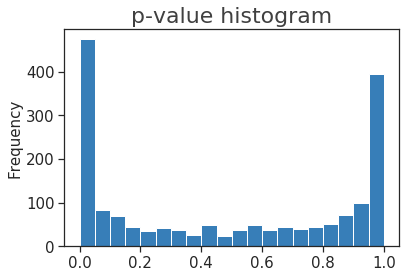

In [36]:
# Change the alternative hypothesis to test to see what genes have more or less than expected STSs (greater / less).
alternative = 'greater'
p_corr_greater = gene_test(dfgenehits, gene_classes, alternative, "fisher_exact", plot=True)

In [39]:
# A table of genes that have a value of selfhits greater than expected. 
if save:
    p_corr_greater.query('count >= 0').sort_values(by='count', ascending=False).to_csv(result_folder + 'greater.csv', sep='\t', index=False)

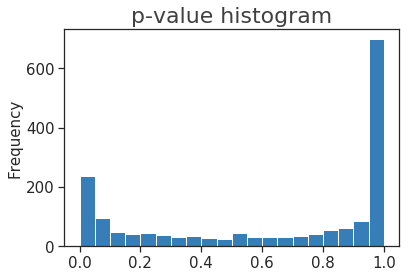

In [40]:
alternative = 'less'
p_corr_less = gene_test(dfgenehits, gene_classes, alternative, "fisher_exact", plot=True)

In [44]:
# A table of genes that have a value of seflhits less than expected. (Showing what genes cannot be targeted for a bacteria, so that it dies.)
if save:
    p_corr_less.query('count >= 0').sort_values(by='total_count', ascending=False).to_csv(result_folder + 'less.csv', sep='\t', index=False)

## Perform test for types individually

In [16]:
df_genome_class = pd.read_csv(data_folder + 'genome.types.csv', sep='\t', 
                              names=['genome_id', 'type', 'class', 'num_genes'], 
                              dtype={'genome_id': str, 'num_genes': int}).set_index('genome_id')
df_genome_class.head()

,type,class,num_genes
genome_id,,,
100053.4,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11
100053.5,CAS-TypeIE,SingleUnknownExtra,8
100053.6,CAS-TypeIE,SingleUnknownExtra,8
100053.7,CAS-TypeIE,SingleUnknownExtra,8
100053.8,CAS-TypeIE,AccompaniedSingleUnknown,8


### Top level plotting (Of STS in groups "No CAS genes", "Incomplete", "Mixed CRISPR System", "Complete CRISPR System")
Plots that make use of grouping of genomes in the large (top level) distinctions.

In [17]:
# Naming used for the groupings.

NOCAS = "No CAS genes"
Mixed = "Mixed CRISPR System"
Complete = "Complete CRISPR System"
Incomplete = "Incomplete CRISPR System"
other = 'Cas-TypeVC | CAS-TypeVIB2'  # 'other'  # Those that exist in all, but not anymore in the selfhit group.
# 'CAS-TypeVC': 1, 'CAS-TypeVIB2': 2

#### First we make a `new_type_group`

In [18]:
def new_type_group(row):
#     print(row)
    if row['num_genes'] == 0:
        return NOCAS
    if "Unclassified" in row['class']:
        return Incomplete
    if "MultipleConfirmed" in row['class']:
        # Confirmed Mixed: The CRISPR array associated confirms that the type is a mixed type.
        return Mixed  
    if "/" in row['type'] or row['type'] == "CAS": 
        return Mixed
    return row['type']
#     if "Confirmed" in row['class']:
#         return "Confirmed " + row['type']
#     if "Accompanied" in row['class']:
#         return "Accompanied " + row['type']
    
df_genome_class['new_type_group'] = df_genome_class.apply(new_type_group, axis=1)

In [19]:
df = df.join(df_genome_class)
df_genome_class[['new_type_group']].head()

,new_type_group
genome_id,
100053.4,CAS-TypeIE
100053.5,CAS-TypeIE
100053.6,CAS-TypeIE
100053.7,CAS-TypeIE
100053.8,CAS-TypeIE


In [20]:
dfgenehits_typed = dfgenehits.join(df_genome_class[['new_type_group']])

In [21]:
dfgenehits_typed.columns

Index(['gene_id', 'seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos', 'spacer_id',
       'hit_ident', 'spacer_size', 'contig_size', 'array_id', 'array_size',
       'array_confid', 'repeat_size', 'array_type', 'genome_type',
       'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',
       'gene_hit', 'gene_class', 'rel_spacer_pos', 'name_spacer_pos',
       'new_type_group'],
      dtype='object')

### Gene enrichment test per type

In [48]:
from IPython.display import display, HTML

def print_test_results(part, alternative, save=False):
    """Perform the gene enrichment test per CRISPR type."""
    
    crispr_type = part['new_type_group'].iloc[0]
    
    
    crispr_type_genome_ids = set(part.index)
    part_gene_classes = dfgenes[dfgenes.index.isin(crispr_type_genome_ids)]["gene_class"].value_counts()
    
    
    p_val = gene_test(part, part_gene_classes, alternative, "fisher_exact")
    
    if not p_val.empty:
        res = p_val.query('count >= 0').sort_values(by='count', ascending=False)
        
        if save:
            res.to_csv(result_folder + 'genes/' + crispr_type + '_' + alternative + '.csv', sep='\t', index=False)
        else:
            print(crispr_type, len(part))
            display(HTML(res.to_html()))
            
    
# save_test_results = partial(print_test_results, save=False, alternative='greater')
dfgenehits_typed.groupby(by='new_type_group').apply(lambda x : print_test_results(x, save=save, alternative='less'))

""


# Pfam analysis
Checking for pfam domains in genes instead of the combined annotation of multiple methods as interproscan does. 

## Read in data

In [23]:
# Just as with the gene selection (note: take the correct ident):
# alias mtawk="mawk -F '\t' -v OFS='\t'"
# mtawk 'FNR==NR{a[$1]=1;next} $1 in a' selection_for_gene_classification pfam.all > pfam.90
# Getting the gene hits
# $26 is the gene_id, $9 is the identity of the hit.
# mtawk 'FNR==NR{if($9>90){a[$1"@"$26]=1;}next} {$16=($1"@"$2 in a)}1' hits.tsv.header.csv pfam.90 > pfam.90.hits
ident = 90
dfpfam = pd.read_csv(data_folder + 'pfam.%d.hits' % ident, sep='\t', usecols=[0, 1, 6, 15],
                      names=['genome_id', 'gene_id', 'pfam_class', 'hit'], 
                      dtype={'genome_id': str, 'hit': int})
dfpfam.head()

,genome_id,gene_id,pfam_class,hit
0,100053.4,JQGS01000192_7,Tetrapyrrole (Corrin/Porphyrin) Methylases,0
1,100053.4,JQGS01000090_14,"Bacterial regulatory proteins, tetR family",0
2,100053.4,JQGS01000039_25,"Respiratory-chain NADH dehydrogenase, 49 Kd subunit",0
3,100053.4,JQGS01000004_86,7TM diverse intracellular signalling,0
4,100053.4,JQGS01000004_86,Stage II sporulation protein E (SpoIIE),0


In [24]:
dfpfam = dfpfam.drop_duplicates().set_index('genome_id')

In [25]:
pfam_classes = dfpfam['pfam_class'].value_counts()
pfam_classes.head()

ABC transporter                                                        577659
Binding-protein-dependent transport system inner membrane component    304812
Response regulator receiver domain                                     297822
Major Facilitator Superfamily                                          292028
Helix-turn-helix domain                                                272766
Name: pfam_class, dtype: int64

In [26]:
pfam_class_hits = dfpfam.query("hit == 1")["pfam_class"].value_counts()
pfam_class_hits.head(50)

AAA domain                                                        339
Phage-related minor tail protein                                  283
Prophage endopeptidase tail                                       262
Phage integrase family                                            260
Initiator Replication protein                                     211
Winged helix-turn-helix DNA-binding                               209
Helicase conserved C-terminal domain                              178
Putative phage tail protein                                       171
Helix-turn-helix domain                                           171
D-alanyl-D-alanine carboxypeptidase                               150
DEAD/DEAH box helicase                                            131
Methyltransferase small domain                                    127
Helix-turn-helix                                                  125
Zonular occludens toxin (Zot)                                     124
Antirestriction prot

The input values for the tests needed to be altered a little, since a gene can contain multiple pfam regions, and not in all genes a pfam is found. 

In [27]:
def get_pfam_stats(dfgenehits, gene_classes, pfam_classes, pfam_class_hits):
    
    gene_stats = get_gene_stats(dfgenehits, gene_classes)
    gene_stats['gene_class_hits'] = pfam_class_hits
    gene_stats['gene_classes'] = pfam_classes
    
    return gene_stats


def pfam_test(dfgenehits, gene_classes, pfam_classes, pfam_class_hits, alternative, method, plot=False):
    gene_stats = get_pfam_stats(dfgenehits, gene_classes, pfam_classes, pfam_class_hits)
    return enrichment_test(gene_stats, alternative, method, plot)

## Pfam for all

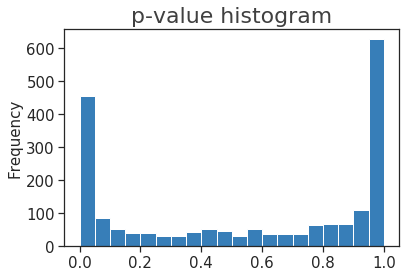

In [49]:
# Change the alternative hypothesis to test to see what genes have more or less than expected STSs (greater / less).
alternative = 'greater'
p_corr_greater = pfam_test(dfgenehits, gene_classes, pfam_classes, pfam_class_hits, alternative, "fisher_exact", plot=True)

In [50]:
if save:
    p_corr_greater.query('count >= 0').sort_values(by='count', ascending=False).to_csv(result_folder + "pfam/greater.csv", sep='\t', index=False)

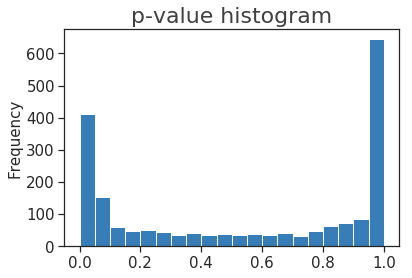

In [51]:
# Change the alternative hypothesis to test to see what genes have more or less than expected STSs (greater / less).
alternative = 'less'
p_corr_less = pfam_test(dfgenehits, gene_classes, pfam_classes, pfam_class_hits, alternative, "fisher_exact", plot=True)

In [52]:
if save:
    p_corr_less.query('count >= 0').sort_values(by='count', ascending=False).to_csv(result_folder + "pfam/less.csv", sep='\t', index=False)

## Pfam test for each type individually

In [54]:
from IPython.display import display, HTML

def print_test_results(part, alternative, save=False):
    """Perform the gene enrichment test per CRISPR type."""
    
    crispr_type = part['new_type_group'].iloc[0]
    
    crispr_type_genome_ids = set(part.index)
    dfpfam_this_type = dfpfam.index.isin(crispr_type_genome_ids)
    
    part_gene_classes = dfgenes[dfgenes.index.isin(crispr_type_genome_ids)]["gene_class"].value_counts()
    part_pfam_classes = dfpfam[dfpfam_this_type]['pfam_class'].value_counts()
    part_pfam_class_hits = dfpfam[dfpfam_this_type].query("hit == 1")['pfam_class'].value_counts()
    
    p_val = pfam_test(part, part_gene_classes, part_pfam_classes, part_pfam_class_hits, alternative, "fisher_exact")
    
    if not p_val.empty:
        res = p_val.query('count >= 0').sort_values(by='count', ascending=False)
        
        if save:
            res.to_csv(result_folder + 'pfam/' + crispr_type + '_' + alternative + '.csv', sep='\t', index=False)
        else:
            print(crispr_type, len(part))
            display(HTML(res.to_html()))
            
    
# save_test_results = partial(print_test_results, save=False, alternative='greater')
dfgenehits_typed.groupby(by='new_type_group').apply(lambda x : print_test_results(x, save=save, alternative='less'))

""
